In [5]:
from IPython.display import clear_output

!pip install datasets twokenize levenshtein

clear_output()

Loading dataset...
Labels in training set:
-  0 = Negative
-  1 = Neutral
-  2 = Positive

Data shapes:
 Positive: (17849, 2)
 Neutral:  (20673, 2)
 Negative: (7093, 2)

Expanding contractions in tweets...
Tokenizing tweets...

Pre-processing Statistics:
                 Step  #Tokens   #|V|  % Reduction  #Tokens_Negative  \
0        Tokenization   554900  44232         0.00            161479   
1         Lowercasing   554900  35727        19.23            161479   
2        Replace URLs   554900  35683         0.12            161479   
3      Replace Emails   554900  35671         0.03            161479   
4  Remove Punctuation   486734  35339         0.93            142729   
5    Remove Stopwords   295854  35176         0.46             85418   
6       Lemmatization   295854  32915         6.43             85418   

   #|V|_Negative  #Tokens_Positive  #|V|_Positive  
0          20184            388094          34862  
1          16784            388094          28140  
2          1

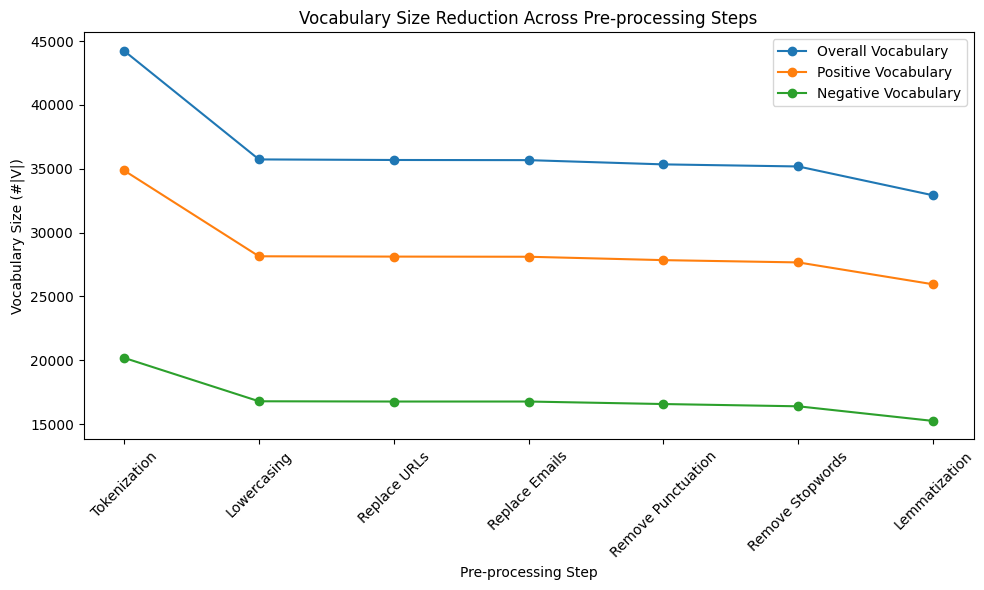


Top 14 Tokens Frequency Comparison (Ranked by Overall Frequency):
       Token  Overall_Freq  Positive_Freq  Negative_Freq
0      @user        9353.0         6756.0         2597.0
1   tomorrow        4290.0         3397.0          892.0
2        may        3754.0         2190.0         1564.0
3        day        2679.0         2201.0          478.0
4        see        1877.0         1566.0            0.0
5      night        1751.0         1465.0            0.0
6      going        1709.0         1282.0          427.0
7       time        1517.0         1142.0          375.0
8       like        1510.0            0.0          597.0
9     friday        1502.0         1223.0            0.0
10       1st           0.0            0.0          492.0
11       get           0.0            0.0          423.0
12        go           0.0            0.0          323.0
13      good           0.0         1146.0            0.0

Vocabulary Analysis:
Positive Vocabulary Size: 25946
Negative Vocabulary Size

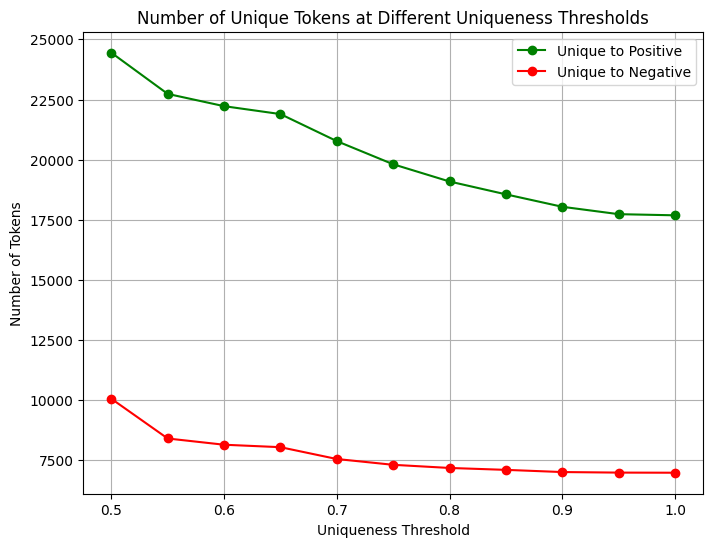

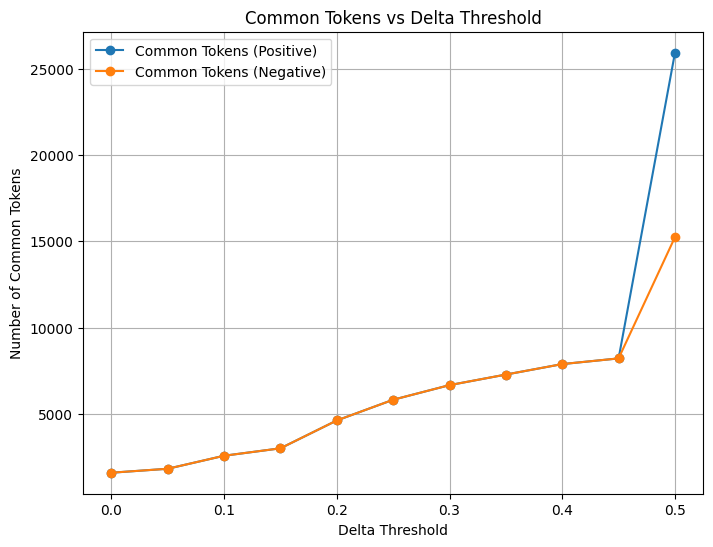


Unique Tokens Not in Valid English Dictionary Words:
['#wolverinenation', 'astate', '#upthedubs', 'woooohooo', 'minisuit', 'omaha', 'rothemere', '#ndvsunc', '#tgit', '#bruuh', 'would\\u2019ve', 'excelent', '#classy', '5-3', '#uptheceltic', 'flori', 'nakita', 'intersented', 'fun-got', '#excusememr']
Total number of unique tokens not in dictionary: 19071
Although our preprocessing pipeline is comprehensive, 
      we cannot remove these non-dictionary tokens because they 
      carry essential sentiment signals and contextual nuances inherent to Twitter language.
      Additionally, we need to further process the document to remove Unicode escape sequences, 
      such as \u002c, which represents a comma, but so far have not found a workaround and it is on the to-do list.


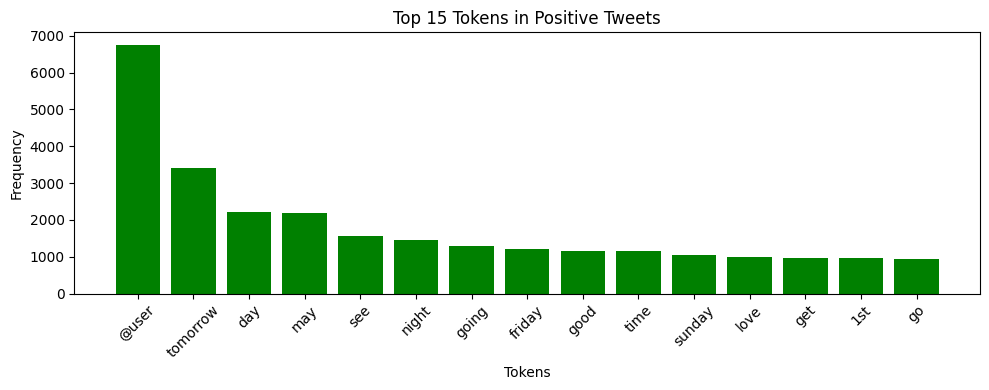

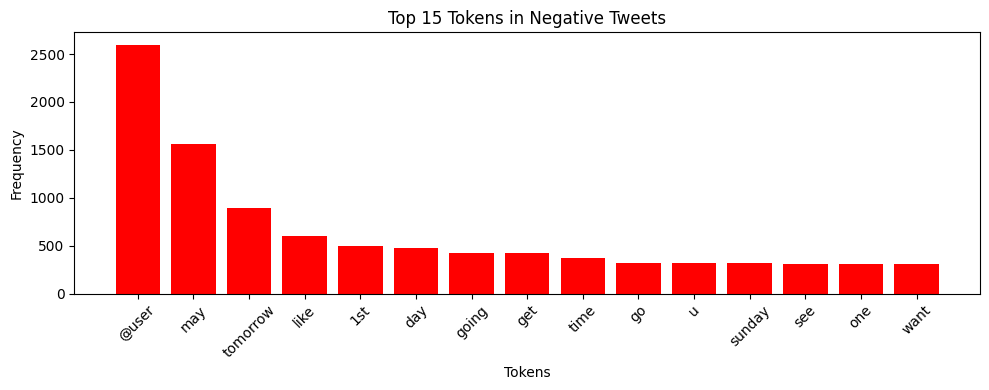


Pre-processing statistics saved to 'preprocessing_stats.csv'.

Starting classification...

Classification Report:
              precision    recall  f1-score   support

    Negative       0.69      0.69      0.69      1419
    Positive       0.88      0.88      0.88      3570

    accuracy                           0.82      4989
   macro avg       0.78      0.78      0.78      4989
weighted avg       0.82      0.82      0.82      4989


Classification Report with TF-IDF Features:
              precision    recall  f1-score   support

    Negative       0.83      0.44      0.58      1419
    Positive       0.81      0.96      0.88      3570

    accuracy                           0.81      4989
   macro avg       0.82      0.70      0.73      4989
weighted avg       0.82      0.81      0.79      4989

TF-IDF reduced performance because it downweighted important sentiment-bearing words 
      in short tweets, making raw frequency counts more effective for classification.

Training addi

In [6]:
"""
Assignment 1: Text Pre-processing, Analysis, and Classification in Twitter

This script processes the tweet_eval sentiment dataset by:
  1. Loading the dataset, expanding contractions, and printing shapes for positive, neutral, and negative tweets.
  2. Filtering out neutral tweets (keeping only positive and negative).
  3. Applying a series of pre-processing steps:
       - Contraction Expansion
       - Tokenization (using twokenize, specialized for Twitter)
       - Lowercasing, URL/Email Replacement, punctuation removal, stopword removal,
         and normalization through lemmatization.
  4. Recording pre-processing statistics (token counts, vocabulary sizes, and % vocabulary reduction) at each step.
  5. Analyzing token frequencies and sentiment-specific vocabulary.
  6. Visualizing the vocabulary reduction and token frequency distributions.
  7. Saving pre-processing statistics to a CSV file.
  8. Classification: Reassembling the final tokens into cleaned texts, extracting n-gram features, splitting the data,
     and training a Multinomial Naive Bayes classifier on the tweets.
"""

# -----------------------------
# Imports and Setup
# -----------------------------
import numpy as np
import re
import html
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

import twokenize
from datasets import load_dataset
clear_output()

import nltk
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Download NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True) # wordnet is a lexical database of English words for lemmatization
nltk.download('words', quiet=True)

# -----------------------------
# 0. Expand Contractions
# -----------------------------
def expand_contractions(text):
    """
    Expand common contractions in the text.
    This normalization helps to standardize informal language.
    Expanding contractions before tokenization ensures
    that the expanded forms are correctly tokenized
    without splitting contraction components improperly.
    """
    text = re.sub(r"(\b)([Aa]re|[Cc]ould|[Dd]id|[Dd]oes|[Dd]o|[Hh]ad|[Hh]as|[Hh]ave|[Ii]s|[Mm]ight|[Mm]ust|[Ss]hould|[Ww]ere|[Ww]ould)n't", r"\1\2 not", text)
    text = re.sub(r"(\b)([Hh]e|[Ii]|[Ss]he|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'ll", r"\1\2 will", text)
    text = re.sub(r"(\b)([Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'re", r"\1\2 are", text)
    text = re.sub(r"(\b)([Ii]|[Ss]hould|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Ww]ould|[Yy]ou)'ve", r"\1\2 have", text)
    text = re.sub(r"(\b)([Cc]a)n't", r"\1\2n not", text)
    text = re.sub(r"(\b)([Ii])'m", r"\1\2 am", text)
    text = re.sub(r"(\b)([Ll]et)'s", r"\1\2 us", text)
    text = re.sub(r"(\b)([Tt]here)'s", r"\1\2 is", text)
    text = re.sub(r"(\b)([Ww])on't", r"\1\2ill not", text)
    text = re.sub(r"(\b)([Ss])han't", r"\1\2hall not", text)
    text = re.sub(r"(\b)([Yy])(?:'all|a'll)", r"\1\2ou all", text)
    return text

# -----------------------------
# 1. Load and Filter Dataset
# -----------------------------
print("Loading dataset...")
dataset = load_dataset("tweet_eval", "sentiment")

# Label mapping for clarity
int_to_label = {2: 'Positive', 1: 'Neutral', 0: 'Negative'}
print("Labels in training set:")
for l in sorted(set(dataset['train']['label'])):
    print(f'- {l:2} = {int_to_label[l]}')

# Create a DataFrame from the training set
df = pd.DataFrame(dataset['train'])

positive_df = df[df['label'] == 2]
neutral_df  = df[df['label'] == 1]
negative_df = df[df['label'] == 0]

print(f'\nData shapes:\n Positive: {positive_df.shape}\n Neutral:  {neutral_df.shape}\n Negative: {negative_df.shape}\n')

# Combine only positive and negative tweets as required
df_filtered = pd.concat([positive_df, negative_df]).reset_index(drop=True)

# --- Apply contraction expansion ---
print("Expanding contractions in tweets...")
df_filtered['text'] = df_filtered['text'].apply(expand_contractions)

# -----------------------------
# 2. Tokenization
# -----------------------------
def tokenize_tweet(tweet):
    """Tokenize tweet using twokenize with HTML unescaping for Twitter-specific handling.
    The `html.unescape` function converts HTML entities in a string back
    to their corresponding characters, ensuring accurate text representation;
    for example, it transforms `I love cats &amp; dogs` into `I love cats & dogs`."""
    text = html.unescape(tweet)
    return twokenize.tokenize(text)

print("Tokenizing tweets...")
tokens_raw_overall  = [tokenize_tweet(tweet) for tweet in df_filtered['text']]
tokens_raw_positive = [tokenize_tweet(tweet) for tweet in positive_df['text']]
tokens_raw_negative = [tokenize_tweet(tweet) for tweet in negative_df['text']]

# -----------------------------
# 3. Normalization Functions
# -----------------------------
def to_lowercase(tokens):
    """Convert tokens to lowercase to merge case variants."""
    return [token.lower() for token in tokens]

def remove_urls(tokens):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    # Replace any token that is a URL with the token 'URL'
    return [("URL" if url_pattern.match(token) else token) for token in tokens]

def remove_emails(tokens):
    email_pattern = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b')
    return [("EMAIL" if email_pattern.match(token) else token) for token in tokens]

def remove_punctuation(tokens):
    """Remove tokens that are purely punctuation but keep tokens that contain emojis."""
    # Define a regex pattern for common emoji Unicode ranges.
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        "]+", flags=re.UNICODE)

    def contains_emoji(token):
        return bool(emoji_pattern.search(token))

    # Keep token if it has alphanumeric characters or contains an emoji.
    return [token for token in tokens if any(char.isalnum() for char in token) or contains_emoji(token)]

def remove_stopwords(tokens):
    """Remove common English stopwords."""
    stop_words = set(stopwords.words('english'))
    return [token for token in tokens if token not in stop_words]

def lemmatize_tokens(tokens):
    """Lemmatize tokens to convert words to their base (dictionary) form.
    Lemmatization preserves meaningful word forms,
    improving sentiment analysis accuracy,
    while stemming can distort meaning with incorrect root forms."""
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

# -----------------------------
# 4. Record Statistics
# -----------------------------
stats = []

def record_stats(step_name, tokens_overall, tokens_positive, tokens_negative, prev_vocab_size=None):
    """Record statistics and calculate the % vocabulary reduction compared to the previous step."""
    total_tokens = sum(len(tokens) for tokens in tokens_overall)
    vocab = set(token for tokens in tokens_overall for token in tokens) # set keeps unique tokens
    vocab_size = len(vocab)

    total_tokens_pos = sum(len(tokens) for tokens in tokens_positive)
    vocab_pos = len(set(token for tokens in tokens_positive for token in tokens))

    total_tokens_neg = sum(len(tokens) for tokens in tokens_negative)
    vocab_neg = len(set(token for tokens in tokens_negative for token in tokens))

    reduction = ((prev_vocab_size - vocab_size) / prev_vocab_size * 100) if prev_vocab_size else 0

    stats.append({
        'Step': step_name,
        '#Tokens': total_tokens,
        '#|V|': vocab_size,
        '% Reduction': round(reduction, 2),
        '#Tokens_Negative': total_tokens_neg,
        '#|V|_Negative': vocab_neg,
        '#Tokens_Positive': total_tokens_pos,
        '#|V|_Positive': vocab_pos
    })
    return vocab_size

# Record initial stats from raw tokenization
initial_vocab_size = record_stats("Tokenization", tokens_raw_overall, tokens_raw_positive, tokens_raw_negative)

# -----------------------------
# 5. Normalization Pipeline
# -----------------------------
# Step 1: Lowercasing
tokens_lower_overall  = [to_lowercase(tokens) for tokens in tokens_raw_overall]
tokens_lower_positive = [to_lowercase(tokens) for tokens in tokens_raw_positive]
tokens_lower_negative = [to_lowercase(tokens) for tokens in tokens_raw_negative]
vocab_size = record_stats("Lowercasing", tokens_lower_overall, tokens_lower_positive, tokens_lower_negative, initial_vocab_size)

# Step 2: Replace URLs
tokens_no_urls_overall  = [remove_urls(tokens) for tokens in tokens_lower_overall]
tokens_no_urls_positive = [remove_urls(tokens) for tokens in tokens_lower_positive]
tokens_no_urls_negative = [remove_urls(tokens) for tokens in tokens_lower_negative]
vocab_size = record_stats("Replace URLs", tokens_no_urls_overall, tokens_no_urls_positive, tokens_no_urls_negative, vocab_size)

# Step 3: Replace Emails
tokens_no_emails_overall  = [remove_emails(tokens) for tokens in tokens_no_urls_overall]
tokens_no_emails_positive = [remove_emails(tokens) for tokens in tokens_no_urls_positive]
tokens_no_emails_negative = [remove_emails(tokens) for tokens in tokens_no_urls_negative]
vocab_size = record_stats("Replace Emails", tokens_no_emails_overall, tokens_no_emails_positive, tokens_no_emails_negative, vocab_size)

# Step 4: Remove Punctuation
tokens_no_punct_overall  = [remove_punctuation(tokens) for tokens in tokens_no_emails_overall]
tokens_no_punct_positive = [remove_punctuation(tokens) for tokens in tokens_no_emails_positive]
tokens_no_punct_negative = [remove_punctuation(tokens) for tokens in tokens_no_emails_negative]
vocab_size = record_stats("Remove Punctuation", tokens_no_punct_overall, tokens_no_punct_positive, tokens_no_punct_negative, vocab_size)

# Step 5: Remove Stopwords
tokens_no_stop_overall  = [remove_stopwords(tokens) for tokens in tokens_no_punct_overall]
tokens_no_stop_positive = [remove_stopwords(tokens) for tokens in tokens_no_punct_positive]
tokens_no_stop_negative = [remove_stopwords(tokens) for tokens in tokens_no_punct_negative]
vocab_size = record_stats("Remove Stopwords", tokens_no_stop_overall, tokens_no_stop_positive, tokens_no_stop_negative, vocab_size)

# Step 6: Lemmatization
tokens_lemmatized_overall  = [lemmatize_tokens(tokens) for tokens in tokens_no_stop_overall]
tokens_lemmatized_positive = [lemmatize_tokens(tokens) for tokens in tokens_no_stop_positive]
tokens_lemmatized_negative = [lemmatize_tokens(tokens) for tokens in tokens_no_stop_negative]
vocab_size = record_stats("Lemmatization", tokens_lemmatized_overall, tokens_lemmatized_positive, tokens_lemmatized_negative, vocab_size)


# -----------------------------
# 6. Analyze Pre-processing Statistics
# -----------------------------
stats_df = pd.DataFrame(stats)
print("\nPre-processing Statistics:")
print(stats_df)

# Plot the vocabulary size reduction across steps
plt.figure(figsize=(10, 6))
plt.plot(stats_df['Step'], stats_df['#|V|'], marker='o', label='Overall Vocabulary')
plt.plot(stats_df['Step'], stats_df['#|V|_Positive'], marker='o', label='Positive Vocabulary')
plt.plot(stats_df['Step'], stats_df['#|V|_Negative'], marker='o', label='Negative Vocabulary')
plt.title("Vocabulary Size Reduction Across Pre-processing Steps")
plt.xlabel("Pre-processing Step")
plt.ylabel("Vocabulary Size (#|V|)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -----------------------------
# 7.1 Token Frequency Analysis
# -----------------------------
# Flatten lists of final tokens for analysis
#combining multiple lists of tokens from individual tweets into a single list
final_tokens_overall  = [token for tokens in tokens_lemmatized_overall for token in tokens]
final_tokens_positive = [token for tokens in tokens_lemmatized_positive for token in tokens]
final_tokens_negative = [token for tokens in tokens_lemmatized_negative for token in tokens]

# Compute frequency distributions using Counter
# returns a dictionary where keys are tokens and values are counts of occurrences
freq_overall  = Counter(final_tokens_overall)
freq_positive = Counter(final_tokens_positive)
freq_negative = Counter(final_tokens_negative)

# PRINT TOP 10 TOKENS FOR EACH FREQUENCY DISTRIBUTION
# Create DataFrames for each frequency distribution
df_overall = pd.DataFrame(freq_overall.most_common(10), columns=['Token', 'Overall_Freq'])
df_positive = pd.DataFrame(freq_positive.most_common(10), columns=['Token', 'Positive_Freq'])
df_negative = pd.DataFrame(freq_negative.most_common(10), columns=['Token', 'Negative_Freq'])
# Merge the DataFrames on the 'Token' column
df_merged = pd.merge(df_overall, df_positive, on='Token', how='outer')
df_merged = pd.merge(df_merged, df_negative, on='Token', how='outer')
# Fill NaN values with 0 for better readability
df_merged.fillna(0, inplace=True)
# Sort the merged DataFrame by 'Overall_Freq' in descending order
df_merged.sort_values(by='Overall_Freq', ascending=False, inplace=True)
# Reset the index to ensure a clean range from 0 to 9
df_merged.reset_index(drop=True, inplace=True)
# Print the sorted DataFrame
print("\nTop 14 Tokens Frequency Comparison (Ranked by Overall Frequency):")
print(df_merged)

# Vocabulary comparison between positive and negative tweets
vocab_positive = set(final_tokens_positive)
vocab_negative = set(final_tokens_negative)
common_tokens = vocab_positive.intersection(vocab_negative)
unique_positive = vocab_positive - vocab_negative
unique_negative = vocab_negative - vocab_positive

print("\nVocabulary Analysis:")
print(f"Positive Vocabulary Size: {len(vocab_positive)}")
print(f"Negative Vocabulary Size: {len(vocab_negative)}")
print(f"Common Tokens: {len(common_tokens)}")
print(f"Unique Positive Tokens: {len(unique_positive)}")
print(f"Unique Negative Tokens: {len(unique_negative)}")

# -----------------------------
# 7.2 : Unique Token Analysis with Thresholds and Common Tokens
# -----------------------------
# Calculate token uniqueness scores
def calculate_token_uniqueness(freq_positive, freq_negative):
    """
    For each token, calculate its uniqueness in the positive and negative classes.
    Uniqueness for the positive class is defined as:
         uniqueness_pos = f_positive / (f_positive + f_negative)
    and for negative as:
         uniqueness_neg = f_negative / (f_positive + f_negative)
    Tokens that appear only in one class get a score of 1 for that class.
    """
    unique_pos = {}
    unique_neg = {}
    all_tokens = set(freq_positive.keys()).union(set(freq_negative.keys()))


    for token in all_tokens:
        fpos = freq_positive.get(token, 0) # if the token is not in the frequency distribution, return 0
        fneg = freq_negative.get(token, 0)
        if fpos > 0 and fneg == 0:
            unique_pos[token] = 1
        elif fneg > 0 and fpos == 0:
            unique_neg[token] = 1
        else:
            total = fpos + fneg
            if total > 0:
                unique_pos[token] = fpos / total
                unique_neg[token] = fneg / total

    return unique_pos, unique_neg

# Calculate the uniqueness scores using the frequency Counters computed earlier
unique_pos, unique_neg = calculate_token_uniqueness(freq_positive, freq_negative)

# 1. Plot: Number of unique tokens for each class across different thresholds
thresholds = np.arange(0.5, 1.05, 0.05)
unique_positive_counts = []
unique_negative_counts = []

for t in thresholds:
    # if the score of a token is greater than or equal to the threshold or 1, count it
    # sum will be the number of unique tokens for each class at each threshold
    pos_count = sum(1 for token, score in unique_pos.items() if score >= t or score == 1)
    neg_count = sum(1 for token, score in unique_neg.items() if score >= t or score == 1)
    unique_positive_counts.append(pos_count)
    unique_negative_counts.append(neg_count)

plt.figure(figsize=(8,6))
plt.plot(thresholds, unique_positive_counts, label='Unique to Positive', marker='o', color='green')
plt.plot(thresholds, unique_negative_counts, label='Unique to Negative', marker='o', color='red')
plt.xlabel('Uniqueness Threshold')
plt.ylabel('Number of Tokens')
plt.title('Number of Unique Tokens at Different Uniqueness Thresholds')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 7.2 : Common Token Analysis Across Different Delta Thresholds
# -----------------------------
# Vary delta thresholds from 0 to 0.5 (inclusive) in steps of 0.05
deltas = np.arange(0, 0.51, 0.05)
common_counts_pos = []
common_counts_neg = []

for d in deltas:
    count_pos = sum(1 for token in unique_pos if 0.5 - d <= unique_pos[token] <= 0.5 + d)
    count_neg = sum(1 for token in unique_neg if 0.5 - d <= unique_neg[token] <= 0.5 + d)
    common_counts_pos.append(count_pos)
    common_counts_neg.append(count_neg)

# Plot the number of common tokens for different delta thresholds for both classes
plt.figure(figsize=(8, 6))
plt.plot(deltas, common_counts_pos, marker='o', label='Common Tokens (Positive)')
plt.plot(deltas, common_counts_neg, marker='o', label='Common Tokens (Negative)')
plt.xlabel('Delta Threshold')
plt.ylabel('Number of Common Tokens')
plt.title('Common Tokens vs Delta Threshold')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 7.3 Unique Tokens Not in Valid English Dictionary Words
# -----------------------------
# Get a set of valid English words
valid_words = set(words.words())

# Find unique words with a score of 1 that are not in the dictionary
unique_tokens_not_in_dict = [word for word in unique_pos if unique_pos[word] == 1 and word.lower() not in valid_words]
unique_tokens_not_in_dict += [word for word in unique_neg if unique_neg[word] == 1 and word.lower() not in valid_words]

# Print the list of unique tokens not in the dictionary
print("\nUnique Tokens Not in Valid English Dictionary Words:")
print(unique_tokens_not_in_dict[:20])  # Print only the first 20 words
print(f"Total number of unique tokens not in dictionary: {len(unique_tokens_not_in_dict)}")
print('''Although our preprocessing pipeline is comprehensive,
      we cannot remove these non-dictionary tokens because they
      carry essential sentiment signals and contextual nuances inherent to Twitter language.
      Additionally, we need to further process the document to remove Unicode escape sequences,
      such as \\u002c, which represents a comma, but so far have not found a workaround and it is on the to-do list.''')

# -----------------------------
# 8. Visualization of Token Frequencies
# -----------------------------
# Plot for top 15 tokens in positive tweets
top_pos = freq_positive.most_common(15)
if top_pos:
    tokens_pos, counts_pos = zip(*top_pos)
    plt.figure(figsize=(10, 4))
    plt.bar(tokens_pos, counts_pos, color='green')
    plt.title("Top 15 Tokens in Positive Tweets")
    plt.xlabel("Tokens")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot for top 15 tokens in negative tweets
top_neg = freq_negative.most_common(15)
if top_neg:
    tokens_neg, counts_neg = zip(*top_neg)
    plt.figure(figsize=(10, 4))
    plt.bar(tokens_neg, counts_neg, color='red')
    plt.title("Top 15 Tokens in Negative Tweets")
    plt.xlabel("Tokens")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# -----------------------------
# 9. Save Pre-processing Statistics
# -----------------------------
csv_filename = 'preprocessing_stats.csv'
stats_df.to_csv(csv_filename, index=False)
print(f"\nPre-processing statistics saved to '{csv_filename}'.")

# -----------------------------
# 10.1 Classification: Train a Multinomial Naive Bayes Classifier
# -----------------------------
print("\nStarting classification...")

# Reassemble final tokens into cleaned text strings (one per tweet)
final_texts = [" ".join(tokens) for tokens in tokens_lemmatized_overall]
labels = df_filtered['label'].values  # 2 for Positive, 0 for Negative

# Split data into training and test sets (using stratification for balanced classes)
# stratify=labels ensures that the same proportion of positive and negative tweets are in both the training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    final_texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# Extract features with CountVectorizer (using uni-grams and bi-grams)
vectorizer = CountVectorizer(ngram_range=(1, 3), max_features=8000, min_df=2, max_df=0.8)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train the Multinomial Naive Bayes classifier
clf = MultinomialNB()
clf.fit(X_train_vec, y_train)

# Predict on the test set and display performance metrics
y_pred = clf.predict(X_test_vec)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# -----------------------------
# 10.2. Classification with TF-IDF Features
# -----------------------------
from sklearn.feature_extraction.text import TfidfTransformer

# Transform the count features into TF-IDF representation
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_vec)
X_test_tfidf = tfidf_transformer.transform(X_test_vec)

# Train a new Multinomial Naive Bayes classifier using TF-IDF features
clf_tfidf = MultinomialNB()
clf_tfidf.fit(X_train_tfidf, y_train)

# Predict on the test set using TF-IDF features and display performance metrics
y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)
print("\nClassification Report with TF-IDF Features:")
print(classification_report(y_test, y_pred_tfidf, target_names=['Negative', 'Positive']))
print('''TF-IDF reduced performance because it downweighted important sentiment-bearing words
      in short tweets, making raw frequency counts more effective for classification.''')


# -----------------------------
# 10.3. Classification without Delta Tokens
# -----------------------------
# Determine and list delta tokens.
# A token is considered "delta" if its positive uniqueness score is close to 0.5,
# meaning its frequency is almost equally distributed between positive and negative.
delta = 0.1  # tolerance around 0.5
delta_tokens = [token for token in unique_pos if 0.5 - delta <= unique_pos[token] <= 0.5 + delta]

# Remove delta tokens from the lemmatized tokens
def remove_delta_tokens(tokens, delta_tokens):
    """Remove delta tokens from the list of tokens."""
    return [token for token in tokens if token not in delta_tokens]

# Apply the removal of delta tokens
tokens_no_delta_overall = [remove_delta_tokens(tokens, delta_tokens) for tokens in tokens_lemmatized_overall]

# Reassemble final tokens into cleaned text strings (one per tweet) after removing delta tokens
final_texts_no_delta = [" ".join(tokens) for tokens in tokens_no_delta_overall]

# Train a new classifier on the filtered data
print("\nTraining additional classifier on data without delta tokens...")

# Split data into training and test sets (using stratification for balanced classes)
X_train_no_delta, X_test_no_delta, y_train_no_delta, y_test_no_delta = train_test_split(
    final_texts_no_delta, labels, test_size=0.2, random_state=42, stratify=labels
)

# Extract features with CountVectorizer (using uni-grams and bi-grams)
vectorizer_no_delta = CountVectorizer(ngram_range=(1, 2), max_features=1000, min_df=2, max_df=0.8)
X_train_vec_no_delta = vectorizer_no_delta.fit_transform(X_train_no_delta)
X_test_vec_no_delta = vectorizer_no_delta.transform(X_test_no_delta)

# Train the Multinomial Naive Bayes classifier
clf_no_delta = MultinomialNB()
clf_no_delta.fit(X_train_vec_no_delta, y_train_no_delta)

# Predict on the test set and display performance metrics
y_pred_no_delta = clf_no_delta.predict(X_test_vec_no_delta)
print("\nClassification Report without Delta Tokens:")
print(classification_report(y_test_no_delta, y_pred_no_delta, target_names=['Negative', 'Positive']))

# -----------------------------
# 11. Conclusions and Findings
# -----------------------------
print("\nConclusions and Findings:")
print("""
- Contraction Expansion effectively standardized informal language in tweets, aiding in consistent tokenization.
- Replacing URLs and emails preserved potentially useful information for classification, as these elements can carry sentiment or context.
- Pre-processing steps, including lowercasing, punctuation and stopword removal, normalization, and rare token filtering, significantly reduced vocabulary size, which is crucial for efficient model training.
- The choice between stemming and lemmatization highlighted the trade-off between aggressive vocabulary reduction and maintaining semantic meaning, with lemmatization proving more effective for sentiment analysis.
- Token frequency analysis identified sentiment-specific common tokens, which are crucial for distinguishing between positive and negative sentiments.
- The classification pipeline using CountVectorizer and Multinomial Naive Bayes provided a strong baseline for sentiment prediction on Twitter data, achieving an accuracy of 82%.
- The use of TF-IDF features reduced performance, likely due to the downweighting of important sentiment-bearing words in short tweets, suggesting that raw frequency counts are more effective in this context.
- Removing delta tokens, which are equally distributed between positive and negative classes, slightly decreased performance, indicating that these tokens may still carry valuable sentiment information.
""")
